In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy import signal
from skimage.feature import match_template
from skimage import color, io, filters
from skimage.util import random_noise
from computeColor import computeImg
import cv2
plt.gray()
%matplotlib inline

# Gradient Based methods
## Lucas-Kanade
The Lucas-Kanade method of determining optical flow tries to solve the optical flow equation $I_x \frac{dx}{dt} + I_y \frac{dy}{dt} = I_t$. This is an underdetermined equation for a single pixel, because we have two unknowns and only one equation (let $u=\frac{dx}{dt}, v=\frac{dy}{dt}$). To fix this, we can take a window about a pixel, and then solve these equations in the least squares sense for the whole patch. If we choose two pixels, it is likely that they would be sufficient, but at such a low level a single pixel that is noisy could throw things off. Using a patch around the pixel fixes this, but also makes the assumption that motion is the same everywhere within the patch, which will become less likely to be true as patch size increases. If we say the patch is pixels $(x_1,y_1), \ldots, (x_n, y_n)$, then we wish to solve the system
\begin{equation}
    \begin{pmatrix}
        I_x(x_1,y_1) & I_y(x_1,y_1)\\
        \vdots & \vdots\\
        I_x(x_n,y_n) & I_y(x_n,y_n)\\
    \end{pmatrix} \begin{pmatrix} u\\v \end{pmatrix}=
    \begin{pmatrix}
        I_t(x_1,y_1)\\
        \vdots \\
        I_t(x_n,y_n)\\
    \end{pmatrix}
\end{equation}
in least sqaures. $I_x$ and $I_y$ can be calculated using a Sobel filter, and then $I_t$ can be calculated using a simple finite difference. Hypothetically, this method could be sped up using QR insertions and deletions, but that would probably take more effort than it is worth. The major cost of this method is that for each pixel a least sqaures solve must be computed, so it would be very expensive on larger images. Note that this least squares problem is solved with a Tikhonov regularizer (of strength $10^{-5}$) to ensure that the covariance is symmetric positive definite.

## Horn-Schunck
The Horn-Schunck method for optical flow calculation introduces a penalty on the Laplacian of the flow, encouraging smoother flow fields. To do this, we have an energy function to minimize:
\begin{equation}
    E(I) = \iint_{x,y\in \Omega} \left((I_x u + I_y v +I_t)^2 + \alpha^2\left(\lVert \nabla u\rVert^2 + \lVert \nabla v\rVert ^{2}\right)\right) dx dy 
\end{equation}
Each of these variables is implicitly a function of $x$ and $y$. Solving this yields a sparse system, which can be solved iteratively with 
\begin{align*}
u^{k+1}&={\overline {u}}^{k}-{\frac {I_{x}(I_{x}{\overline {u}}^{k}+I_{y}{\overline {v}}^{k}+I_{t})}{\alpha ^{2}+I_{x}^{2}+I_{y}^{2}}}\\
v^{k+1}&={\overline {v}}^{k}-{\frac {I_{y}(I_{x}{\overline {u}}^{k}+I_{y}{\overline {v}}^{k}+I_{t})}{\alpha ^{2}+I_{x}^{2}+I_{y}^{2}}}\\
\end{align*}
where ${\overline{u}(x,y)}$ is a weighted average of neighbors of $(x,y)$ (which does not include pixel $(x,y)$ itself). Essentially, it is taking the Laplacian of the image without the $-1$ in the center.

## Results
We can see that the Lucas-Kanade flow calculation tends to output better results than the Horn-Schunk method. In the absence of noise, Lucas-Kanade performs quite well, even with no image smoothing or window weights. When we add noise, it is more effective to smooth each image using a Gaussian filter before processing. Doing this, the Lucas-Kanade algorithm still works in the presence of small amounts of noise. The Horn-Schunck algorithm produces less nice results, probably due to the slight noise levels in the image. In addition, in the sphere, where there is a sharp boundary between motion and no motion, the flow field is "propagated" beyond the boundaries of the motion to preserve the smoothness. This fault could probably be improved by assigning a prior to alpha, assuming it is usually large, but at some points can go down to zero be very small, allowing large changes in $u$ and $v$.

In [2]:
def kanade_motion(im1, imnext,imprev=None, step_size=10, region_size=15, smoothing_sigma=0, window_sigma=0):
    assert im1.shape==im2.shape
    rr = region_size // 2
    if smoothing_sigma > 0:
        im1 = filters.gaussian(im1, smoothing_sigma)
        imnext = filters.gaussian(imnext, smoothing_sigma)
        imprev = filters.gaussian(imprev, smoothing_sigma) if imprev is not None else None
    dx = filters.sobel_h(im1)
    dy = -filters.sobel_v(im1)
    if imprev is None:
        dt = imnext-im1
    else:
        dt = (imnext-imprev)/2
    outputs = np.zeros((im1.shape[0]//step_size, im1.shape[1]//step_size, 4))
    n, m = im1.shape
    delta=1e-5 # ensure covariance is spd
    if window_sigma>0:
        a = np.zeros((region_size, region_size)) # compute window weights
        a[rr, rr] = 1
        W = filters.gaussian(a, window_sigma).reshape(-1)
        W /= W.sum()
    else:
        W = np.ones(region_size**2) / float(region_size**2)
    
    for i in range(rr, n-rr, step_size):
        for j in range(rr, m-rr, step_size):
            reg_s = np.s_[i-rr:i+rr+region_size%2, j-rr:j+rr+region_size%2]
            lhs = np.hstack((dx[reg_s].reshape(-1, 1), dy[reg_s].reshape(-1, 1)))
            
            rhs = lhs.T.dot(W * dt[reg_s].reshape(-1))
            lhs = lhs.T.dot(W[:, None]*lhs) + delta*np.eye(2)
            u,v = np.linalg.solve(lhs, rhs)
            outputs[i//step_size,j//step_size,:] = (j, i, v, u)
    return outputs

## No smoothing

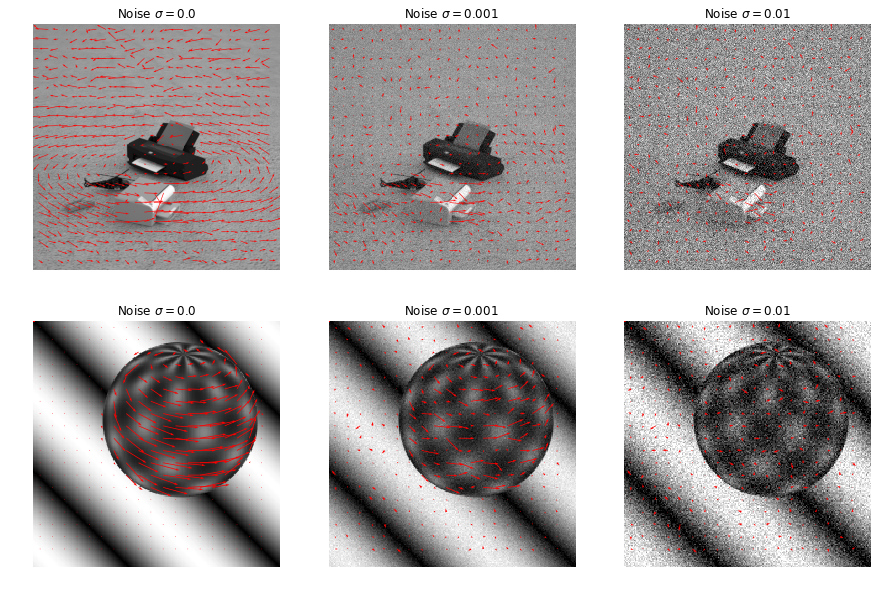

In [3]:
plt.figure(figsize=(15,10))
files = sorted(glob.glob('./data/image/seq1/*.png'), key=lambda x: int(x.split('/')[-1][5:-4]))
im1, im2, im3 = io.imread(files[0], as_grey=True), io.imread(files[1], as_grey=True), io.imread(files[2], as_grey=True)
vv = [0.0, 0.001, 0.01]
for i in range(3):
    np.random.seed(124123)
    var = vv[i]
    gim1 = random_noise(im1, var=var)
    gim2 = random_noise(im2, var=var)
    gim3 = random_noise(im3, var=var)
    
    outputs = kanade_motion(gim2, gim3, gim1, step_size=10, region_size=10, window_sigma=0)
    plt.subplot(2,3,i+1)
    plt.imshow(gim2)
    plt.title(f'Noise $\sigma={var}$')
    plt.quiver(*outputs.reshape(-1,4).T, color='r', scale=10)
    plt.axis('off')

files = sorted(glob.glob('./data/sphere/sphere.*.png'), key=lambda x: int(x.split('/')[-1].split('.')[-2]))
im1, im2, im3 = io.imread(files[0], as_grey=True), io.imread(files[1], as_grey=True), io.imread(files[2], as_grey=True)
for i in range(3):
    np.random.seed(124123)
    var = vv[i]
    gim1 = random_noise(im1, var=var)
    gim2 = random_noise(im2, var=var)
    gim3 = random_noise(im3, var=var)
    outputs = kanade_motion(gim2, gim3, gim1, step_size=10, region_size=10, window_sigma=0)
    plt.subplot(2,3,i+4)
    plt.imshow(gim2)
    plt.title(f'Noise $\sigma={var}$')
    plt.quiver(*outputs.reshape(-1,4).T, color='r', scale=10)
    plt.axis('off')

## Smoothed images

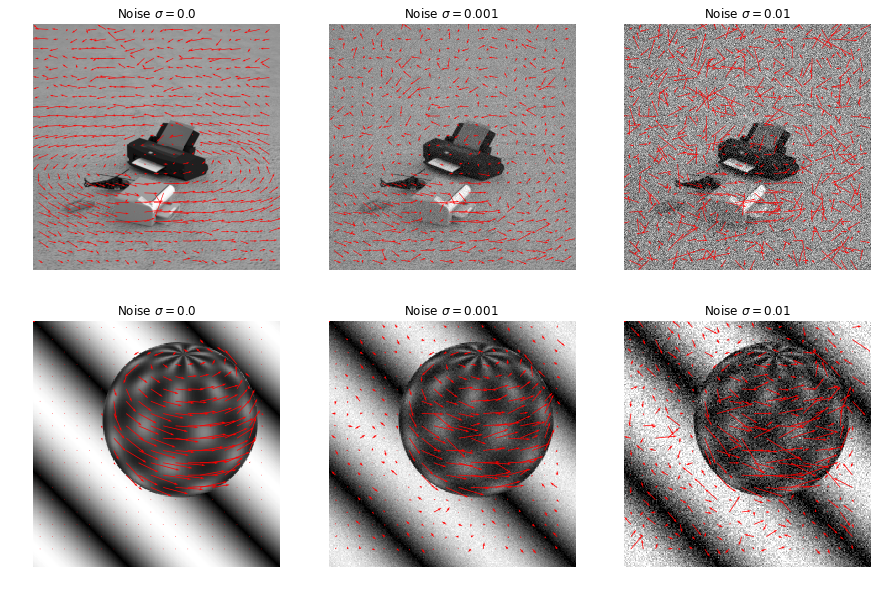

In [4]:
plt.figure(figsize=(15,10))
files = sorted(glob.glob('./data/image/seq1/*.png'), key=lambda x: int(x.split('/')[-1][5:-4]))
im1, im2, im3 = io.imread(files[0], as_grey=True), io.imread(files[1], as_grey=True), io.imread(files[2], as_grey=True)
vv = [0.0, 0.001, 0.01]
for i in range(3):
    np.random.seed(124123)
    var = vv[i]
    gim1 = random_noise(im1, var=var)
    gim2 = random_noise(im2, var=var)
    gim3 = random_noise(im3, var=var)
    
    outputs = kanade_motion(gim2, gim3, gim1, step_size=10, region_size=10, smoothing_sigma=i, window_sigma=7)
    plt.subplot(2,3,i+1)
    plt.imshow(gim2)
    plt.title(f'Noise $\sigma={var}$')
    plt.quiver(*outputs.reshape(-1,4).T, color='r', scale=10)
    plt.axis('off')

files = sorted(glob.glob('./data/sphere/sphere.*.png'), key=lambda x: int(x.split('/')[-1].split('.')[-2]))
im1, im2, im3 = io.imread(files[0], as_grey=True), io.imread(files[1], as_grey=True), io.imread(files[2], as_grey=True)
for i in range(3):
    np.random.seed(124123)
    var = vv[i]
    gim1 = random_noise(im1, var=var)
    gim2 = random_noise(im2, var=var)
    gim3 = random_noise(im3, var=var)
    outputs = kanade_motion(gim2, gim3, gim1, step_size=10, region_size=10, smoothing_sigma=i, window_sigma=7)
    plt.subplot(2,3,i+4)
    plt.imshow(gim2)
    plt.title(f'Noise $\sigma={var}$')
    plt.quiver(*outputs.reshape(-1,4).T, color='r', scale=10)
    plt.axis('off')

In [5]:
# gauss_sum = filters.gaussian()
def wbar(u, sigma=1):
    ker = np.array([[1,2,1], [2,0,2], [1,2,1.]])
    ker/=ker.sum()
    return signal.convolve2d(u, ker, 'same', boundary='symm')
#     return filters.gaussian(u, sigma)-filters.gaussian(np.array([[1.]]),sigma, mode='constant')[0,0]*u

def horn_motion(im1, imnext,imprev=None, alpha=0.001, niter=10):
    # TODO: https://en.wikipedia.org/wiki/Horn%E2%80%93Schunck_method says the proper update scheme
    assert im1.shape==im2.shape

    dx = filters.sobel_h(im1)
    dy = filters.sobel_v(im1)
    if imprev is None:
        dt = filters.gaussian(imnext)-filters.gaussian(im1)
    else:
        dt = (filters.gaussian(imnext)-filters.gaussian(imprev))/2

    u = np.zeros_like(im1)
    v = np.zeros_like(im1)
    
    normalizer = alpha**2 + dx**2 + dy**2
    for _ in range(niter):
        barv = wbar(v)
        baru = wbar(u)
        num = dx * baru + dy*barv + dt
        frac = num/normalizer
        u = baru - dx*frac
        v = barv - dy*frac
    x,y = np.mgrid[:im1.shape[0],:im1.shape[1]]
    return np.stack((y, x, v, -u), axis=2)

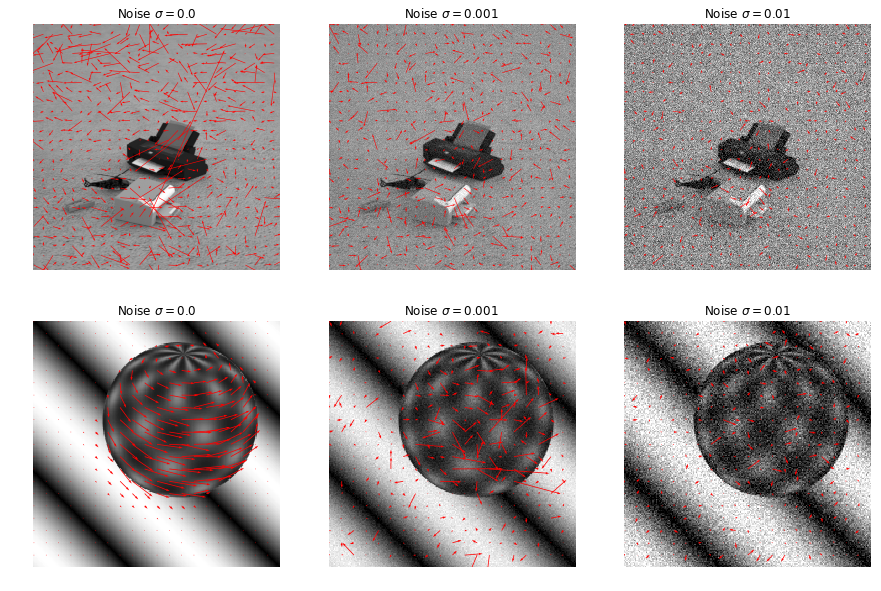

In [6]:
plt.figure(figsize=(15,10))
files = sorted(glob.glob('./data/image/seq1/*.png'), key=lambda x: int(x.split('/')[-1][5:-4]))
im1, im2, im3 = io.imread(files[0], as_grey=True), io.imread(files[1], as_grey=True), io.imread(files[2], as_grey=True)
vv = [0.0, 0.001, 0.01]
alphas = [0.001, 0.01, 0.1]
for i in range(3):
    np.random.seed(124123)
    var = vv[i]
    gim1 = random_noise(im1, var=var)
    gim2 = random_noise(im2, var=var)
    gim3 = random_noise(im3, var=var)
    outputs = horn_motion(gim2, gim3, gim1, alpha=alphas[i], niter=400)
    plt.subplot(2,3,i+1)
    plt.imshow(gim2)
    plt.title(f'Noise $\sigma={var}$')
    plt.quiver(*outputs[::10,::10].reshape(-1,4).T, color='r', scale=10)
    plt.axis('off')

files = sorted(glob.glob('./data/sphere/sphere.*.png'), key=lambda x: int(x.split('/')[-1].split('.')[-2]))
im1, im2, im3 = io.imread(files[0], as_grey=True), io.imread(files[1], as_grey=True), io.imread(files[2], as_grey=True)
for i in range(3):
    np.random.seed(124123)
    var = vv[i]
    gim1 = random_noise(im1, var=var)
    gim2 = random_noise(im2, var=var)
    gim3 = random_noise(im3, var=var)
    outputs = horn_motion(gim2, gim3, gim1, alpha=alphas[i], niter=400)
    plt.subplot(2,3,i+4)
    plt.imshow(gim2)
    plt.title(f'Noise $\sigma={var}$')
    plt.quiver(*outputs[::10, ::10].reshape(-1,4).T, color='r', scale=10)
    plt.axis('off')

## Color representation of flow

max flow: 1.1938 flow range: u = -0.807 .. 1.194; v = -0.695 .. 0.408

max flow: 3.9108 flow range: u = -2.087 .. 3.704; v = -1.881 .. 2.639

max flow: 1.2663 flow range: u = -0.585 .. 1.262; v = -0.923 .. 0.750

max flow: 1.5148 flow range: u = -0.960 .. 1.448; v = -1.309 .. 0.914



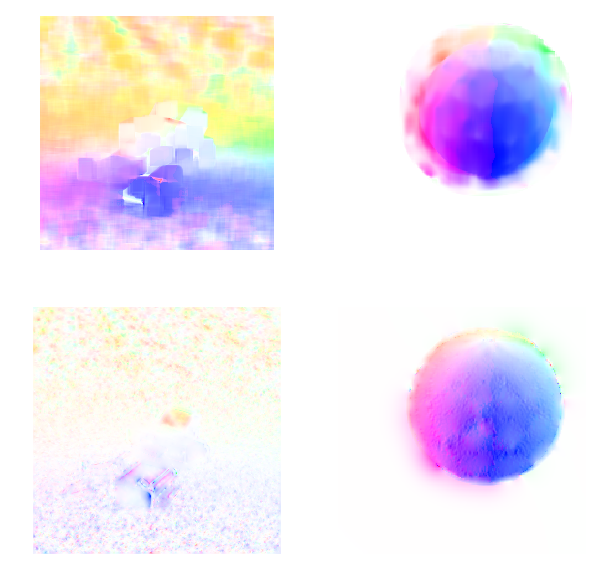

In [7]:
files = sorted(glob.glob('./data/image/seq1/*.png'), key=lambda x: int(x.split('/')[-1][5:-4]))
im1, im2, im3 = io.imread(files[0], as_grey=True), io.imread(files[1], as_grey=True), io.imread(files[2], as_grey=True)
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
outputs = kanade_motion(im2, im3, im1, step_size=1)
plt.imshow(computeImg(outputs[:, :, 2:]));
plt.axis('off')

plt.subplot(2,2,3)
outputs = horn_motion(im2, im3, im1, alpha=0.01, niter=200)
plt.imshow(computeImg(outputs[:, :, 2:]));
plt.axis('off')

files = sorted(glob.glob('./data/sphere/sphere.*.png'), key=lambda x: int(x.split('/')[-1].split('.')[-2]))
im1, im2, im3 = io.imread(files[0], as_grey=True), io.imread(files[1], as_grey=True), io.imread(files[2], as_grey=True)

plt.subplot(2,2,2)
outputs = kanade_motion(im2, im3, im1, step_size=1)
plt.imshow(computeImg(outputs[:, :, 2:]));
plt.axis('off')

plt.subplot(2,2,4)
outputs = horn_motion(im2, im3, im1, alpha=0.01, niter=200)
plt.imshow(computeImg(outputs[:, :, 2:]));
plt.axis('off');